# Digit recognizer

In [15]:
### Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

### Importing MNIST dataset
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [16]:
### Splitting the training data
evl=train.iloc[38000:,:]
evl2=train.iloc[37900:38000,:]
train=train.iloc[0:34000,:]

In [17]:
### Splitting labels and features
train_l=train["label"]
train_f=train.iloc[:,1:]

evl_l=evl["label"]
evl_f=evl.iloc[:,1:]

evl2_l=evl["label"]
evl2_f=evl.iloc[:,1:]

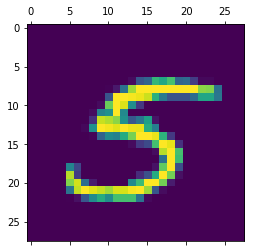

In [18]:
### Showing random example
random=np.random.randint(len(train)-1)
_, ax = plt.subplots()
ax.matshow(train_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

In [19]:
def construct_feature_columns():
    return set([tf.feature_column.numeric_column("pixels",shape=784)])

In [20]:
def create_training_input_fn(features2,labels2,batch_size,epochs=None):
    def _input_fn():
        idx=np.random.permutation(features2.index.values)
        features=features2.reindex(idx)
        features={"pixels":features}
        labels=np.array(labels2[idx])
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size).repeat(epochs)
        ds=ds.shuffle(40000)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [29]:
def create_predict_input_fn(features2,labels2,batch_size):
    def _input_fn():
        features={"pixels":features2}
        labels=np.array(labels2)
        
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [22]:
training_input_fn=create_training_input_fn(evl_f,evl_l,batch_size=1)

In [30]:
predict_input_fn=create_predict_input_fn(evl2_f,evl2_l,batch_size=1)

In [24]:
classifier=tf.estimator.LinearClassifier(feature_columns=construct_feature_columns(), 
                                         n_classes=10, 
                                         optimizer="Ftrl",
                                         config=tf.estimator.RunConfig(keep_checkpoint_max=1))

INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\Steven\\AppData\\Local\\Temp\\tmptan9v9_i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000017508A75A90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [25]:
classifier.train(input_fn=training_input_fn,steps=5)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\Steven\AppData\Local\Temp\tmptan9v9_i\model.ckpt.
INFO:tensorflow:loss = 2.3025851, step = 1
INFO:tensorflow:Saving checkpoints for 5 into C:\Users\Steven\AppData\Local\Temp\tmptan9v9_i\model.ckpt.
INFO:tensorflow:Loss for final step: 2690.1328.


In [43]:
pred=classifier.predict(input_fn=predict_input_fn)

In [44]:
pred

<generator object Estimator.predict at 0x0000017506DBB200>

In [45]:
pred=np.array([item['class_ids'][0] for item in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\Steven\AppData\Local\Temp\tmptan9v9_i\model.ckpt-5
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [50]:
pred

array([0, 8, 8, ..., 0, 0, 8], dtype=int64)